In [30]:
from shapely import geometry, ops
from shapely.geometry import Point,mapping, LineString, Polygon
import numpy as np
import rasterio
from rasterio import plot, mask
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
from scipy.ndimage import filters

In [31]:
OS_National_Grids = gpd.read_file(os.path.join('OS-British-National-Grids-main','OS-British-National-Grids-main','os_bng_grids.gpkg'),layer='1km_grid')
study_area_shapely = OS_National_Grids[OS_National_Grids['tile_name'] == "SX7677"].geometry.cascaded_union

Haytor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(os.path.join('OS Elevation','Download_Haytor_Elevation_2035988','terrain-5-dtm_4600215','sx','SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation,[study_area], filled=False, crop=False)


network_links = gpd.read_file(os.path.join('Study_area','SX7677','network_links_dpn.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area','SX7677','network_nodes_dpn.geojson'))


## Normalising values

In [32]:
network_links['angle_normalised'] = network_links['angle'].div(network_links['angle'].sum())
network_links['total_time_normalised'] = network_links['total_time']\
    .div(network_links['total_time'].sum())
network_links['DPN_normalised'] = network_links['DPN'].div(network_links['DPN'].sum())
network_links['surface_cost_normalised'] = network_links['surface_cost'].div(network_links['surface_cost'].sum())



## Set Start and End point

In [33]:
## Set Start and End point
# tramway SW to  tramway NE
#points = [6,1633]

#to SW to Haytor rocks
#points = [6,1670]

# to SW to Haytor rocks
#points = [6,1119]

#points = ['al_492','al_1670']

#points = ['dpn_132','al_1670']

#points = ['dpn_1','dpn_265']

points = ['int_dpn1', 'dpn_1022']

#points = ["al_6","al_1670"]

# points = ["al_6","dpn_896"]

# points = ["al_6","al_868"]

# points = ['dpn_749','dpn_676']

## Add weights

In [34]:
# using point allocation
# easy = [0.2,0,0.6,0.2]
# intermediate = [0.1,0.2,0.3,0.4]
# expert = [0,0.8,0.1,0.1]

#using ranking sum
# easy = [0.2,0.1,0.4,0.3]
# intermediate = [0.1,0.3,0.4,0.2]
# expert = [0.1,0.4,0.2,0.3]


#using ranking exponent
easy = [0.014,0.003,0.89,0.093]
intermediate = [0.003,0.093,0.89,0.014]
expert = [0.003,0.89,0.014,0.89]

#using ranking reciprocal
# easy = [0.16,0.12,0.48,0.24]
# intermediate = [0.12,0.24,0.48,0.16]
# expert = [0.12,0.48,0.16,0.24]

#using AHP
# easy= [0.40816269, 0.37576408, 0.16324949, 0.05282373]
# intermediate =[0.05483313, 0.18761354, 0.42783578, 0.32971755]
# expert = [0.03716924, 0.64349957, 0.16151403, 0.15781716]


### Easy

In [35]:
graph = nx.DiGraph()
for index,row in network_links.iterrows():

    angle = (row.angle_normalised * easy[0])*100000
    travel_time = (row.total_time_normalised * easy[1])*100000
    dpn = (row.DPN_normalised * easy[2])*100000
    surface_cost = (row.surface_cost_normalised * easy[3])*100000
    # Weighted Sum method
    wsm = angle + travel_time + dpn + surface_cost

    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],
               length=row.length,
               weighted_sum=wsm)

# get the shortest path with time weight
weighted_path = nx.dijkstra_path(graph, source=points[0], target=points[1], weight='weighted_sum')

geom = []
links = []
first_node = weighted_path[0]
for node in weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

weighted_path_easy_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})

## Intermediate

In [36]:
graph = nx.DiGraph()
for index,row in network_links.iterrows():

    angle = (row.angle_normalised * intermediate[0])*100000
    travel_time = (row.total_time_normalised * intermediate[1])*100000
    dpn = (row.DPN_normalised * intermediate[2])*100000
    surface_cost = (row.surface_cost_normalised * intermediate[3])*100000
    # Weighted Sum method
    wsm = angle + travel_time + dpn + surface_cost

    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],
               length=row.length,
               weighted_sum=wsm)

# get the shortest path with time weight
weighted_path = nx.dijkstra_path(graph, source=points[0], target=points[1], weight='weighted_sum')

geom = []
links = []
first_node = weighted_path[0]
for node in weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

weighted_path_intermediate_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})

## expert

In [37]:
graph = nx.DiGraph()
for index,row in network_links.iterrows():

    angle = (row.angle_normalised * expert[0])*100000
    travel_time = (row.total_time_normalised * expert[1])*100000
    dpn = (row.DPN_normalised * expert[2])*100000
    surface_cost = (row.surface_cost_normalised * expert[3])*100000
    # Weighted Sum method
    wsm = angle + travel_time + dpn + surface_cost

    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],
               length=row.length,
               weighted_sum=wsm)

# get the shortest path with time weight
weighted_path = nx.dijkstra_path(graph, source=points[0], target=points[1], weight='weighted_sum')

geom = []
links = []
first_node = weighted_path[0]
for node in weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

weighted_path_expert_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


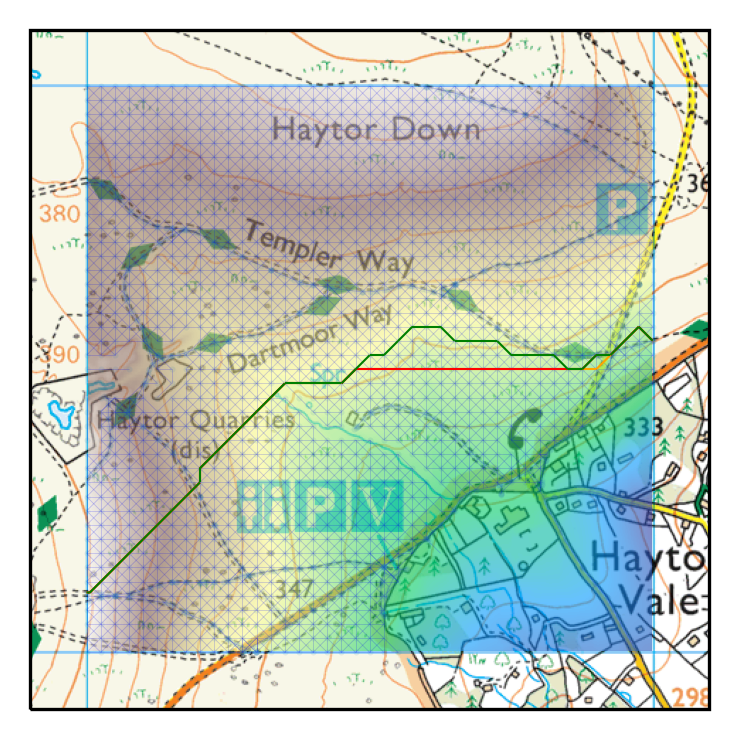

In [38]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                   cmap='terrain')

# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.1)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.1)

# display path
weighted_path_easy_gpd.plot(ax=ax, zorder=7, edgecolor='green', linewidth=0.5, label='easy')
weighted_path_intermediate_gpd.plot(ax=ax, zorder=5, edgecolor='orange', linewidth=0.5, label='intermediate')
weighted_path_expert_gpd.plot(ax=ax, zorder=6, edgecolor='red', linewidth=0.5, label='expert')

#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0] - 100, study_area_shapely.bounds[2] + 100,
                   study_area_shapely.bounds[1] - 100, study_area_shapely.bounds[3] + 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

Only using Detailed-Path-Network

In [39]:
graph = nx.DiGraph()
dpn_network_links = network_links.loc[network_links['DPN'] == 1]
for index,row in dpn_network_links.iterrows():
    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],length=row.length,dpn=row.DPN)

# get the shortest path with time weight
weighted_path = nx.dijkstra_path(graph, source='int_dpn1', target='dpn_1022', weight='dpn')

In [40]:
geom = []
links = []
dpn= []
first_node = weighted_path[0]
for node in weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    dpn.append(row.DPN)
    first_node = node

weighted_path_dpn_gpd = gpd.GeoDataFrame({'fid': links,'dpn':dpn, 'geometry': geom})

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


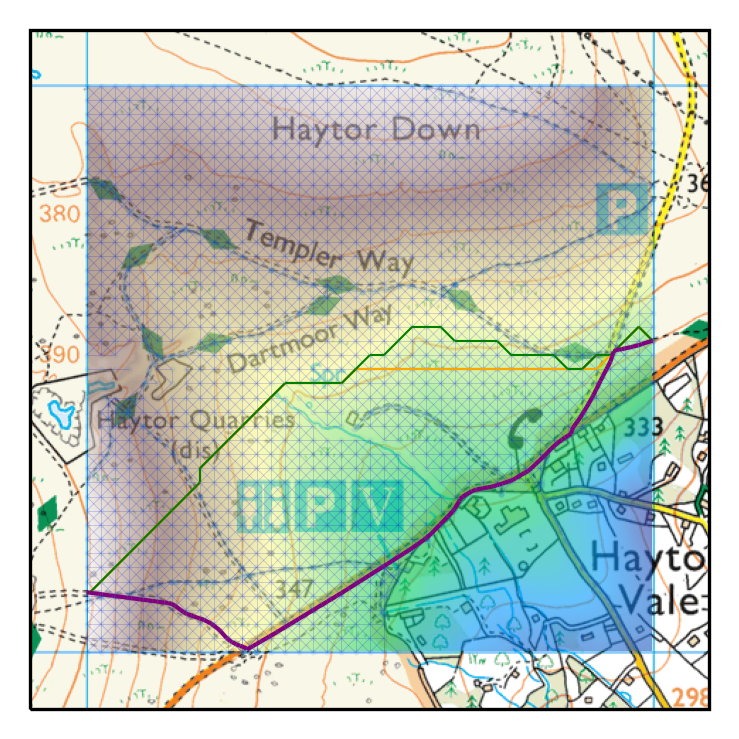

In [42]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,cmap='terrain')

# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.1)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.1)

# display path
weighted_path_easy_gpd.plot(ax=ax, zorder=7, edgecolor='green', linewidth=0.5, label='easy')
weighted_path_intermediate_gpd.plot(ax=ax, zorder=6, edgecolor='orange', linewidth=0.5, label='intermediate')
weighted_path_expert_gpd.plot(ax=ax, zorder=5, edgecolor='red', linewidth=0.5, label='expert')
weighted_path_dpn_gpd.plot(ax=ax, zorder=8, edgecolor='purple', linewidth=1, label='dpn')

#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0] - 100, study_area_shapely.bounds[2] + 100,
                   study_area_shapely.bounds[1] - 100, study_area_shapely.bounds[3] + 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

## Only using surface_cost

In [43]:
graph = nx.Graph()
for index, row in network_links.iterrows():
    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'], time=row.total_time, surface_cost=row.surface_cost )

In [44]:
#land_use
path = nx.dijkstra_path(graph, source=points[0], target=points[1], weight="surface_cost")

geom = []
links = []
first_node = path[0]
for node in path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

land_use_path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})

In [45]:
#land_use_path_gpd.to_file("Study_area/SX7677/land_use_path_gpd.geojson", driver='GeoJSON',crs='EPSG:27700')

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


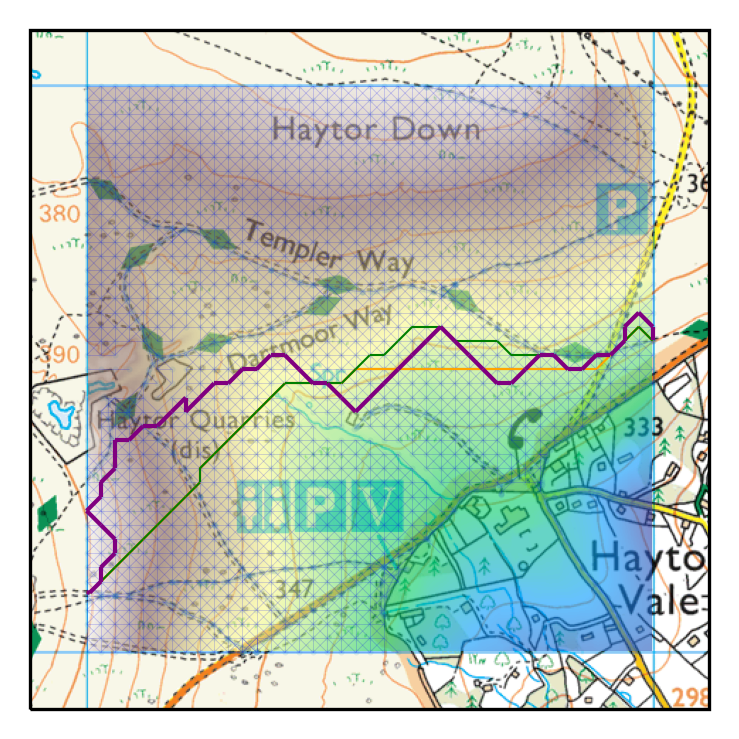

In [46]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                   cmap='terrain')

# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.1)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.1)

# display path
weighted_path_easy_gpd.plot(ax=ax, zorder=7, edgecolor='green', linewidth=0.5, label='easy')
weighted_path_intermediate_gpd.plot(ax=ax, zorder=6, edgecolor='orange', linewidth=0.5, label='intermediate')
weighted_path_expert_gpd.plot(ax=ax, zorder=5, edgecolor='red', linewidth=0.5, label='expert')
land_use_path_gpd.plot(ax=ax, zorder=8, edgecolor='purple', linewidth=1, label='dpn')

#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0] - 100, study_area_shapely.bounds[2] + 100,
                   study_area_shapely.bounds[1] - 100, study_area_shapely.bounds[3] + 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()


In [47]:
def smooth_linestring(path_gpd, smooth_sigma):
    """
    Uses a gauss filter to smooth out the LineString coordinates.
    """
    geom = path_gpd['geometry'].tolist()
    multi_line = geometry.MultiLineString(geom)
    multi_line
    linestring = ops.linemerge(multi_line)
    linestring
    smooth_x = np.array(filters.gaussian_filter1d(
        linestring.xy[0],
        smooth_sigma)
    )
    smooth_y = np.array(filters.gaussian_filter1d(
        linestring.xy[1],
        smooth_sigma)
    )
    smoothed_coords = np.hstack((smooth_x, smooth_y))
    smoothed_coords = zip(smooth_x, smooth_y)
    linestring_smoothed = LineString(smoothed_coords)
    new_path_gpd = gpd.GeoSeries({'geometry': linestring_smoothed})
    return new_path_gpd

In [48]:
linestring_smoothed_easy = smooth_linestring(weighted_path_easy_gpd, 2)
linestring_smoothed_intermediate = smooth_linestring(weighted_path_intermediate_gpd, 2)
linestring_smoothed_expert = smooth_linestring(weighted_path_expert_gpd, 2)
linestring_smoothed_land_use = smooth_linestring(land_use_path_gpd, 2)

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


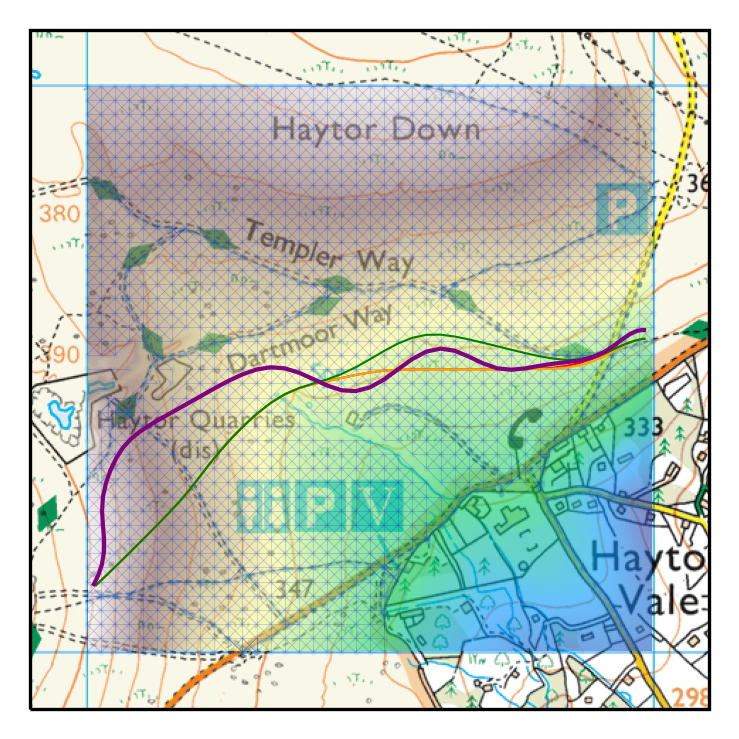

In [49]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                   cmap='terrain')

# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.1)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.1)

# display path
linestring_smoothed_easy.plot(ax=ax, zorder=7, edgecolor='green', linewidth=0.5, label='easy')
linestring_smoothed_intermediate.plot(ax=ax, zorder=6, edgecolor='orange', linewidth=0.5, label='intermediate')
linestring_smoothed_expert.plot(ax=ax, zorder=5, edgecolor='red', linewidth=0.5, label='expert')
linestring_smoothed_land_use.plot(ax=ax, zorder=8, edgecolor='purple', linewidth=1, label='dpn')

#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0] - 100, study_area_shapely.bounds[2] + 100,
                   study_area_shapely.bounds[1] - 100, study_area_shapely.bounds[3] + 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()
